In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('twitter_sentiment_data.csv')
df

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153
...,...,...,...
43938,1,"Dear @realDonaldTrump,\nYeah right. Human Medi...",791307031919550464
43939,1,What will your respective parties do to preven...,791316857403936768
43940,2,RT @MikkiL: UN Poll Shows Climate Change Is th...,791357509101621249
43941,0,RT @taehbeingextra: i still can$q$t believe th...,791390042136641537


> Remove tweets of class News

In [3]:
df.drop(df[df['sentiment'] == 2].index, inplace = True)

In [4]:
df = df.reset_index()

In [5]:
for col in df.columns:
    print(col)

index
sentiment
message
tweetid


In [6]:
df = df.drop('index', 1)

In [7]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,0,Unamshow awache kujinga na iko global warming ...,793125429418815489


In [8]:
df.sentiment.unique()

array([-1,  1,  0])

In [41]:
labels = df.sentiment.unique()

> **Classes:**
> - 2(News): the tweet links to factual news about climate change
> - 1(Pro): the tweet supports the belief of man-made climate change
> - 0(Neutral: the tweet neither supports nor refutes the belief of man-made climate change
> -  -1(Anti): the tweet does not believe in man-made climate change

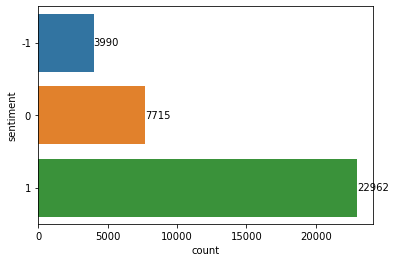

In [37]:
count_plot = sns.countplot(data = df,
                           y = 'sentiment')
count_plot.bar_label(count_plot.containers[0])
plt.show()

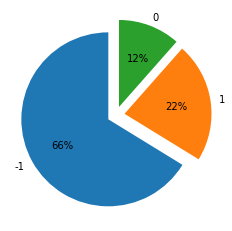

In [43]:
plt.pie(df["sentiment"].value_counts(),
        labels=labels,
        autopct="%1.0f%%",
        startangle=90,
        explode=tuple([0.1] * len(labels)))
plt.show()

In [10]:
count = df.sentiment.value_counts()
count.name = "Count"

percent = df.sentiment.value_counts(normalize=True)
percent.name = "Percentage"

display(pd.concat([count, percent], axis=1))

,Count,Percentage
1,22962,0.662359
0,7715,0.222546
-1,3990,0.115095


In [11]:
df_pro = df[df.sentiment == 1]
df_neutral = df[df.sentiment == 0]
df_anti = df[df.sentiment == -1]
#df_news = df[df.sentiment == 2]

In [12]:
#df_pro.head()

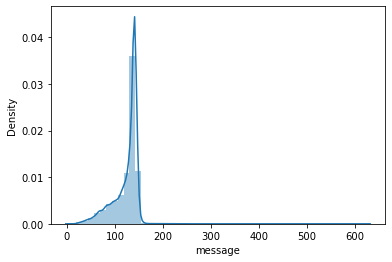

In [13]:
sns.distplot(df.message.str.len())

plt.show()

In [14]:
df.message.str.len().describe()

count    34667.000000
mean       123.693368
std         25.847211
min          7.000000
25%        114.000000
50%        135.000000
75%        140.000000
max        623.000000
Name: message, dtype: float64

In [47]:
import re
import nltk
import itertools
from tqdm.auto import tqdm

In [54]:
top20 = {}


for sentiment, group in df.groupby("sentiment"):
    hashtags = group["message"].apply(lambda tweet: re.findall(r"#(\w+)", tweet))
    hashtags = itertools.chain(*hashtags)
    hashtags = [ht.lower() for ht in hashtags]
    
    frequency = nltk.FreqDist(hashtags)
    
    df_hashtags = pd.DataFrame({
        "hashtags": list(frequency.keys()),
        "counts": list(frequency.values()),
    })
    top15_htags = df_hashtags.nlargest(20, columns=["counts"])
    
    top15[sentiment] = top15_htags.reset_index(drop=True)

display(pd.concat(top15, axis=1).head(n=10))

-1                     0                       1       
        hashtags counts       hashtags counts         hashtags counts
0           tcot     59        climate     59          climate    541
1           maga     31  climatechange     51    climatechange    384
2        climate     25          trump     20   beforetheflood    265
3  climatechange     25  globalwarming     18     actonclimate    156
4          pjnet     23    debatenight     16   parisagreement    108
5          trump     21          cop21     14  imvotingbecause     93
6  globalwarming     19         auspol     13            cop22     86
7       fakenews     15          cop22     11           auspol     76
8             p2     13        science      9            cop21     73
9       teaparty     11           maga      9    globalwarming     73

In [58]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet

In [ ]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [ ]:
def lemmatizer(df):
    df["length"] = df["message"].str.len()
    df["tokenized"] = df["message"].apply(word_tokenize)
    df["parts-of-speech"] = df["tokenized"].apply(nltk.tag.pos_tag)
    
    def str2wordnet(tag):
        conversion = {"J": wordnet.ADJ, "V": wordnet.VERB, "N": wordnet.NOUN, "R": wordnet.ADV}
        try:
            return conversion[tag[0].upper()]
        except KeyError:
            return wordnet.NOUN
    
    wnl = WordNetLemmatizer()
    df["parts-of-speech"] = df["parts-of-speech"].apply(
        lambda tokens: [(word, str2wordnet(tag)) for word, tag in tokens]
    )
    df["lemmatized"] = df["parts-of-speech"].apply(
        lambda tokens: [wnl.lemmatize(word, tag) for word, tag in tokens]
    )
    df["lemmatized"] = df["lemmatized"].apply(lambda tokens: " ".join(map(str, tokens)))
    
    return df

In [ ]:
lmt_df = lemmatizer(df)
lmt_df

In [ ]:
plt.figure(figsize=(15, 15))
sns.boxplot(x="sentiment", y="length", data=df, palette=("Blues_d"))
plt.title("Tweet Length Distribution for each Sentiment")
plt.show()


In [15]:
# We will go over the sampled text as below.
# Every tweets share the common rule starting with @ + airlines' name.
# We can also see there are http formats, emojis, and hashtag

print(df.message[0].split(),'\n')
print(df.message[1].split(),'\n')
print(df.message[100].split(),'\n')
print(df.message[1000].split(),'\n')
#print(df.message[10000].split())

['@tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom'] 

['RT', '@NatGeoChannel:', 'Watch', '#BeforeTheFlood', 'right', 'here,', 'as', '@LeoDiCaprio', 'travels', 'the', 'world', 'to', 'tackle', 'climate', 'change', 'https://t.co/LkDehj3tNn', 'httÃ¢â‚¬Â¦'] 

['RT', '@xeni:', "#Halloween's", 'ok', 'but', 'if', 'you', 'really', 'wanna', 'get', 'scared', 'watch', 'this', 'new', '@NatGeoÃ¢â‚¬â€¹', 'climate', 'change', 'doc', 'with', '@LeoDiCaprio', 'https://t.co/rUFMÃ¢â‚¬Â¦'] 

['RT', '@qz:', 'A', 'new', 'report', 'shows', 'that', 'our', 'efforts', 'to', 'fight', 'global', 'warming', 'are', 'paying', 'off', 'in', 'the', 'biggest', 'way', 'yet', 'https://t.co/fPYZlR98PZ'] 



In [16]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

names = ['global warming', 'climate change']

def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

def clean_stopword(d):
    stop_words = stopwords.words('english')
    for name in names:
        stop_words.append(name)
    return " ".join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 1])

def tokenize(d):
    return word_tokenize(d)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kysgattu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kysgattu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
df['final_text']= df.message.apply(clean_text).apply(clean_stopword).apply(tokenize)
df.final_text.head()

0    [tiniebeany, climate, change, interesting, hus...
1    [rt, natgeochannel, watch, beforetheflood, rig...
2    [fabulous, leonardo, dicaprios, film, climate,...
3    [rt, mickfanning, watched, amazing, documentar...
4    [unamshow, awache, kujinga, na, iko, global, w...
Name: final_text, dtype: object

In [18]:
print(" ".join(df.final_text[0]),'\n')
print(" ".join(df.final_text[1]),'\n')
print(" ".join(df.final_text[100]),'\n')
print(" ".join(df.final_text[1000]),'\n')
#print(" ".join(df.final_text[10000]))

tiniebeany climate change interesting hustle global warming planet stopped warming yes suv boom 

rt natgeochannel watch beforetheflood right leodicaprio travels world tackle climate change httpstcolkdehjtnn htt 

rt xeni halloweens ok really wan na get scared watch new natgeo climate change doc leodicaprio httpstcorufm 

rt qz new report shows efforts fight global warming paying biggest way yet httpstcofpyzlrpz 



In [19]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
vader.polarity_scores(" ".join(df.final_text[0]))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kysgattu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.103, 'neu': 0.432, 'pos': 0.465, 'compound': 0.6908}

In [20]:
len(df)

34667

In [21]:
#texts = ' '
for i in range(len(df)):
    print(df.final_text[i])

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [22]:
texts = [" ".join(df.final_text[i]) for i in range(len(df))]

In [23]:
texts = [" ".join(df.final_text[i]) for i in range(len(df))]

print(df.message[0])
print(texts[0])
print(vader.polarity_scores(texts[0]), f'--> Actual Classification: {df.sentiment[0]}', '\n')

print(df.message[1])
print(texts[1])
print(vader.polarity_scores(texts[1]), f'--> Actual Classification: {df.sentiment[1]}', '\n')

print(df.message[10])
print(texts[10])
print(vader.polarity_scores(texts[10]), f'--> Actual Classification: {df.sentiment[10]}', '\n')

print(df.message[100])
print(texts[100])
print(vader.polarity_scores(texts[100]), f'--> Actual Classification: {df.sentiment[100]}', '\n')

print(df.message[1000])
print(texts[1000])
print(vader.polarity_scores(texts[1000]), f'--> Actual Classification: {df.sentiment[1000]}', '\n')

#print(df.message[10000])
#print(texts[10000])
#print(vader.polarity_scores(texts[10000]), f'--> Actual Classification: {df.sentiment[10000]}')


@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom
tiniebeany climate change interesting hustle global warming planet stopped warming yes suv boom
{'neg': 0.103, 'neu': 0.432, 'pos': 0.465, 'compound': 0.6908} --> Actual Classification: -1 

RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦
rt natgeochannel watch beforetheflood right leodicaprio travels world tackle climate change httpstcolkdehjtnn htt
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} --> Actual Classification: 1 

Now's the time: we need a strong #FTT that works for those hardest hit by climate change and poverty!
nows time need strong ftt works hardest hit climate change poverty
{'neg': 0.212, 'neu': 0.577, 'pos': 0.212, 'compound': 0.0} --> Actual Classification: 1 

RT @xeni: #Halloween's ok but if you really wanna get scared watc

In [25]:
# preprocessing before drawing wordcloud separating the sentiment.

pro = df[df.sentiment == 1].message.apply(clean_text).apply(clean_stopword).apply(tokenize)
pro = [" ".join(pro.values[i]) for i in range(len(pro))]
pro = [" ".join(pro)][0]

anti = df[df.sentiment == -1].message.apply(clean_text).apply(clean_stopword).apply(tokenize)
anti = [" ".join(anti.values[i]) for i in range(len(anti))]
anti = [" ".join(anti)][0]

neutral = df[df.sentiment == 0].message.apply(clean_text).apply(clean_stopword).apply(tokenize)
neutral = [" ".join(neutral.values[i]) for i in range(len(neutral))]
neutral = [" ".join(neutral)][0]

#news = df[df.sentiment == 2].message.apply(clean_text).apply(clean_stopword).apply(tokenize)
#news = [" ".join(news.values[i]) for i in range(len(news))]
#news = [" ".join(news)][0]

print(len(pro), len(anti), len(neutral))

2190971 367261 637868


In [26]:
from wordcloud import WordCloud

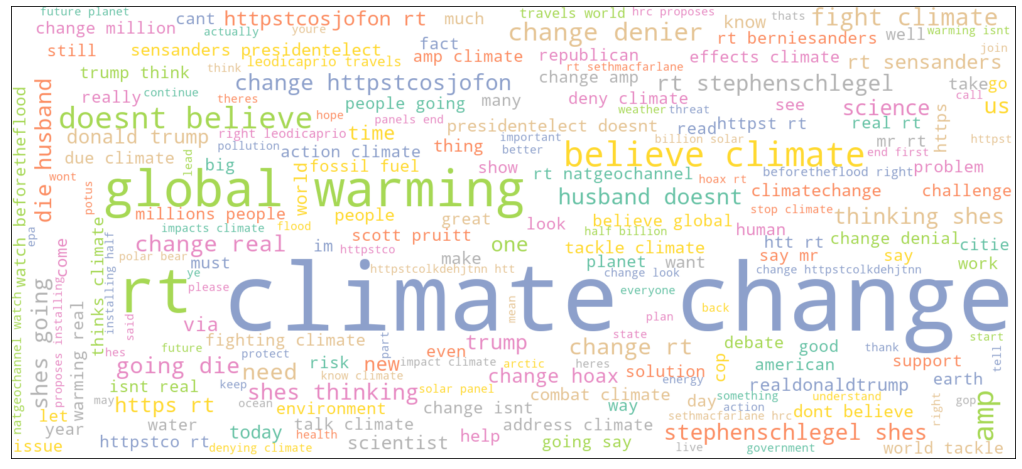

In [27]:
plt.figure(figsize=(18,15))
wc_pro = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(pro)

plt.imshow(wc_pro,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

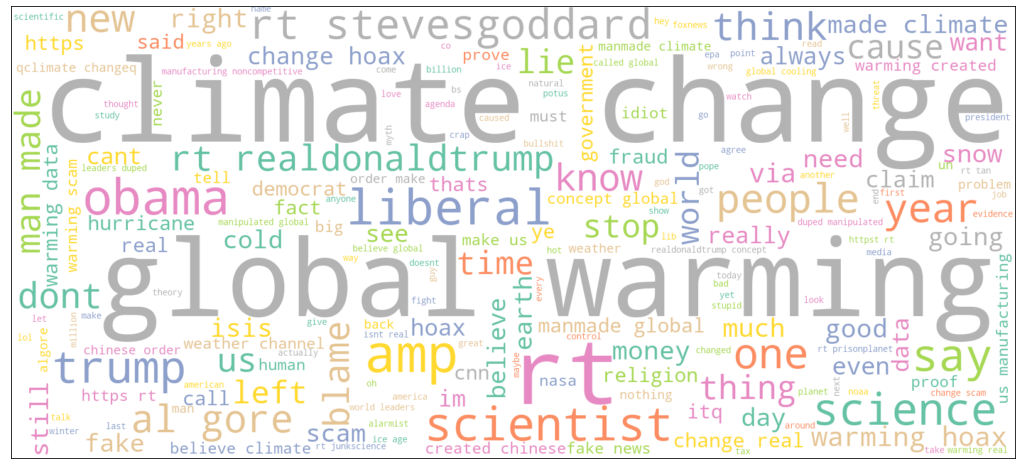

In [28]:
plt.figure(figsize=(18,15))
wc_anti = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(anti)

plt.imshow(wc_anti,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

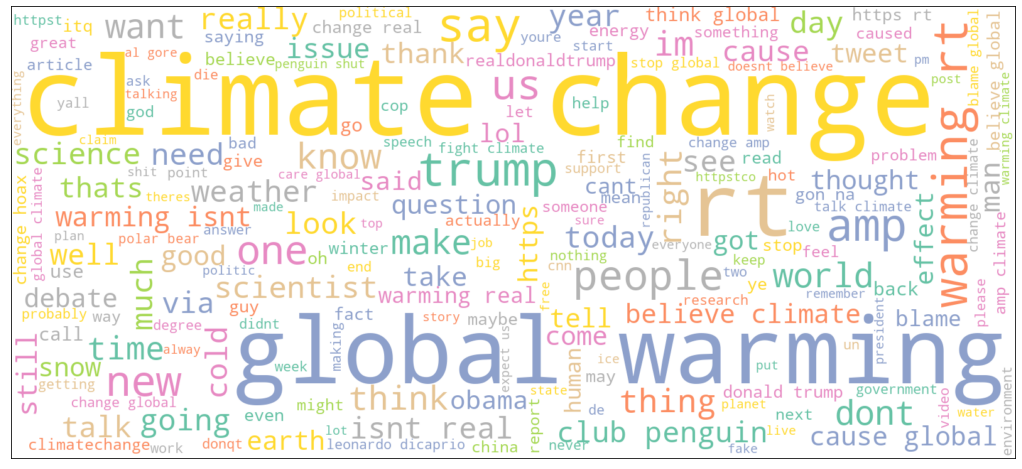

In [29]:
plt.figure(figsize=(18,15))
wc_neutral = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(neutral)

plt.imshow(wc_neutral,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

In [30]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [31]:
df.final_text

0        [tiniebeany, climate, change, interesting, hus...
1        [rt, natgeochannel, watch, beforetheflood, rig...
2        [fabulous, leonardo, dicaprios, film, climate,...
3        [rt, mickfanning, watched, amazing, documentar...
4        [unamshow, awache, kujinga, na, iko, global, w...
                               ...                        
34662    [aikbaatsunithi, global, warming, negative, ef...
34663    [dear, realdonaldtrump, yeah, right, human, me...
34664    [respective, parties, prevent, climate, change...
34665    [rt, taehbeingextra, still, canqt, believe, gi...
34666    [likeabat, zachhaller, wealthy, fossil, fuel, ...
Name: final_text, Length: 34667, dtype: object

In [32]:
for i in range(len(df)):
    df['final_text'][i] = " ".join(df['final_text'][i])

In [33]:
df['final_text'][:3]

0    tiniebeany climate change interesting hustle g...
1    rt natgeochannel watch beforetheflood right le...
2    fabulous leonardo dicaprios film climate chang...
Name: final_text, dtype: object

In [34]:
X = df.final_text
y = df.sentiment

In [35]:
model_params = {'random_state':42}
model_list = [LogisticRegression(**model_params, solver='liblinear'),
              SVC(**model_params)]
model_names = ['LogisticRegression','SupportVectorMachine']

c = CountVectorizer()
X_c = c.fit_transform(X)

tf = TfidfVectorizer()
X_tf = tf.fit_transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list, model_names):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(df.index, df.sentiment)):        
        X_c_trn = X_c[trn_idx]
        X_tf_trn = X_tf[trn_idx]
        y_trn = df.loc[trn_idx, 'sentiment']
        
        X_c_vld = X_c[vld_idx]
        X_tf_vld = X_tf[vld_idx]
        y_vld = df.loc[vld_idx, 'sentiment']        
        
        model.fit(X_c_trn, y_trn)
        c_pred_col = f"{model_name}_ct_pred"
        df.loc[vld_idx, c_pred_col] = model.predict(X_c_vld)
        
        model.fit(X_tf_trn, y_trn)
        tf_pred_col = f"{model_name}_tf_pred"
        df.loc[vld_idx, tf_pred_col] = model.predict(X_tf_vld)

    print(f"Model: {model_name}, CountVectorizer, Accuracy: {accuracy_score(df.sentiment, df[c_pred_col]):.3%}")
    print(f"Model: {model_name}, TfidfVectorizer, Accuracy: {accuracy_score(df.sentiment, df[tf_pred_col]):.3%}\n")

Model: LogisticRegression, CountVectorizer, Accuracy: 77.852%
Model: LogisticRegression, TfidfVectorizer, Accuracy: 75.270%



KeyboardInterrupt: 

In [ ]:
from gensim.models import Word2Vec

texts_w2v = df.final_text.apply(tokenize).to_list()
w2v = Word2Vec(sentences = texts_w2v, window = 3,
               vector_size = 100, min_count = 5, workers = 4, sg = 1)

In [ ]:
texts_w2v[:3]